In [1]:
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

workspace = Workspace (
   resource_id = "", # Your resource_id goes here
   location = "eastus"
)

provider = AzureQuantumProvider(workspace=workspace)



In [2]:
def phase_oracle(n, name = 'Uf'):
    # Function to create oracle circuit
    # Marking the |110> state
    
    qc = QuantumCircuit(n, name=name)
    qc.x(0)
    qc.ccx(0,1,3)
    qc.ccx(2,3,4)
    qc.ccx(0,1,3)
    qc.x(0)

    return qc

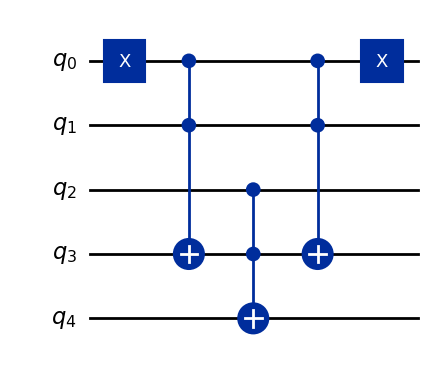

In [3]:
# Diagram of the oracle circuit above
n = 5
qc = QuantumCircuit(n)
qc.x(0)
qc.ccx(0,1,3)
qc.ccx(2,3,4)
qc.ccx(0,1,3)
qc.x(0)

qc.draw('mpl')

In [4]:
def diffuser(n, name='V'):
    qc = QuantumCircuit(n, name=name)

    for qubit in range(n-2): #first layer of Hadamards in diffuser
        qc.h(qubit)
        
    for i in range(n-2):
        qc.x(i)
        
    qc.ccx(0,1,3)
    qc.ccx(2,3,4)
    qc.ccx(0,1,3)

    for i in range(n-2):
        qc.x(i)

    for qubit in range(n-2): # second layer of Hadamards in diffuser
        qc.h(qubit)

    return qc

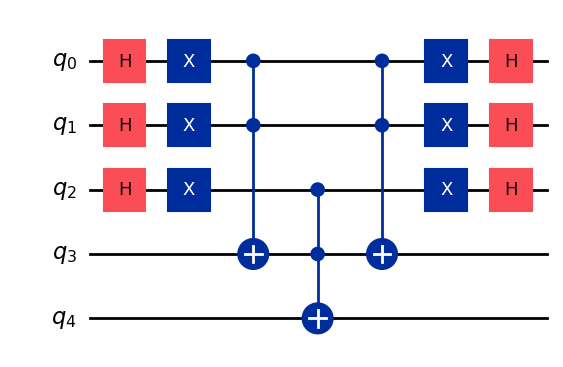

In [5]:
# Diagram of the diffuser circuit above
n = 5
qc = QuantumCircuit(n)

for qubit in range(n-2):
    qc.h(qubit)
        
for i in range(n-2):
    qc.x(i)
        
qc.ccx(0,1,3)
qc.ccx(2,3,4)
qc.ccx(0,1,3)

for i in range(n-2):
    qc.x(i)

for qubit in range(n-2):
    qc.h(qubit)

qc.draw('mpl')

r =  2


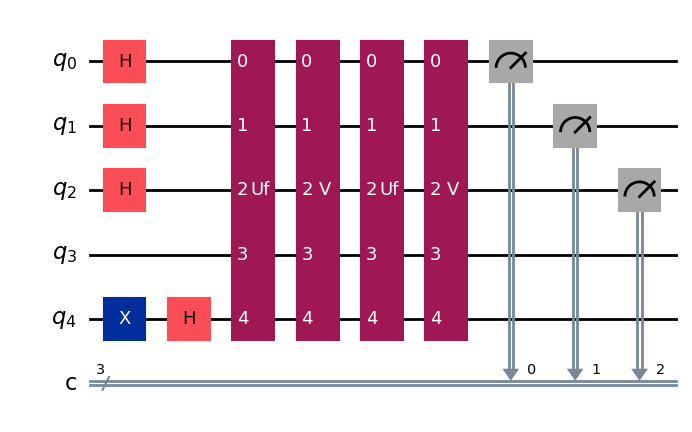

In [6]:
n = 5
grover_circuit = QuantumCircuit(n, n-2)
mu = 1 # number of solutions

r = int(np.floor(np.pi / 4 * np.sqrt(2**(n-2)/mu))) # determine r
print('r = ', r)

grover_circuit.h(range(n-2)) # step 1: apply Hadamard gates on all working qubits

# put ancilla in state |->
grover_circuit.x(n-1)
grover_circuit.h(n-1)

# apply r rounds of the oracle and diffuser
for i in range(r):
    grover_circuit.append(phase_oracle(n), range(n))
    grover_circuit.append(diffuser(n), range(n))

grover_circuit.measure(range(n-2), range(n-2))

grover_circuit.draw('mpl')

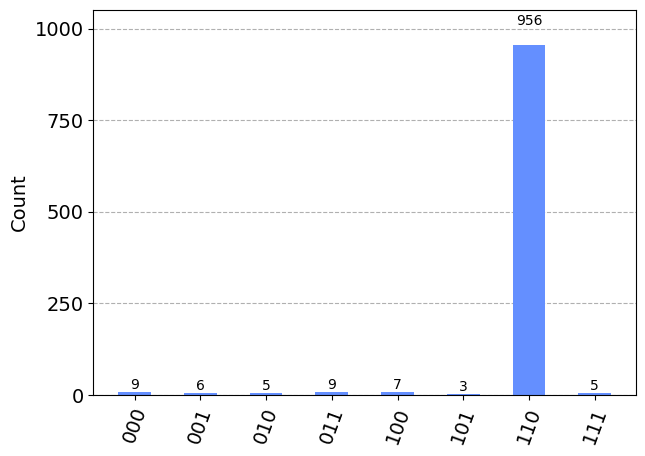

In [7]:
backend = Aer.get_backend('qasm_simulator')
transpiled = transpile(grover_circuit, backend)
job = backend.run(transpiled, shots = 1000)
counts = job.result().get_counts()

plot_histogram(counts)

In [8]:
# Quantum resource estimation for the algorithm

backend = provider.get_backend('microsoft.estimator')

job = backend.run(grover_circuit,
    qubitParams={
        "name": "qubit_gate_us_e4"
    },
    qecScheme={
        "name": "surface_code"
    },
    errorBudget=0.01)
result = job.result()
result

......

Runtime,70 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (1,800,000 nanosecs) multiplied by the 39 logical cycles to run the algorithm. If however the duration of a single T factory (here: 1,800,000 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,10.00k,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (18) (with a logical error rate of 7.12e-6) multiplied by the clock frequency (555.56), which is the number of logical cycles per second."
Physical qubits,360,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 324 physical qubits to implement the algorithm logic, and 36 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,18,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 5$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 18$ logical qubits."
Algorithmic depth,39,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 3 single-qubit measurements, the 0 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 12 CCZ and 0 CCiX gates in the input program, as well as No rotations in algorithm multi-qubit measurements for each of the 0 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,39,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 39. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,556,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 2 millisecs.
Number of T states,48,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 12 CCZ and 0 CCiX gates, as well as No rotations in algorithm for each of the 0 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,2,"Number of T factories capable of producing the demanded 48 T states during the algorithm's runtime The total number of T factories 2 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{48 \cdot 1,800,000\;\text{ns}}{1 \cdot 70,200,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,24,"Number of times all T factories are invoked In order to prepare the 48 T states, the 2 copies of the T factory are repeatedly invoked 24 times."
Physical algorithmic qubits,324,Number of physical qubits for the algorithm after layout The 324 are the product of the 18 logical qubits after layout and the 18 physical qubits that encode a single logical qubit.
